In [15]:
# FYI, review paper on data augmentation in DL:
# https://journalofbigdata.springeropen.com/articles/10.1186/s40537-019-0197-0

In [16]:
# import libraries
import numpy as np
import torch

# import transformations and dataset/loader
import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset,DataLoader

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/tmp/ipykernel_21652/1514840182.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [17]:
# Importing Required Libraries

# Import the MNIST dataset from torchvision
import torchvision

# Import numpy for data manipulation
import numpy as np

# Load the MNIST dataset and download it if necessary
MNIST = torchvision.datasets.MNIST(".", download=True)

# Extract the training data, training labels, test data, and test labels from the MNIST dataset
train_data = MNIST.train_data
train_labels = MNIST.train_labels
test_data = MNIST.test_data
test_labels = MNIST.test_labels

# Combining and Subsampling Data

# Vertically combine the training and test data arrays
data = np.vstack([train_data, test_data])

# Vertically combine the training and test labels arrays
labels = np.hstack([train_labels, test_labels])

# Set a random seed for reproducibility
np.random.seed(42)

# Randomly select 20,000 samples from the combined data without replacement
indices = np.random.choice(len(data), size=20000, replace=False)

# Update the 'data' array to include only the selected samples
data = data[indices]

# Update the 'labels' array to include only the labels corresponding to the selected samples
labels = labels[indices]

# Reshape the 'data' array to ensure it is a 2D array
data = data.reshape(data.shape[0], -1)

# Explanation:
# This code imports the MNIST dataset using torchvision and extracts the training and test data along with their labels.
# It then vertically combines the training and test data arrays, as well as the labels arrays, to create a larger dataset.
# Randomly, 20,000 samples are selected from the combined dataset without replacement to reduce its size.
# Finally, both the 'data' and 'labels' arrays are reshaped into 2D arrays, which is a common format for input to machine learning models.


In [18]:


# Reshape the 'data' array to ensure it is a 2D array
data = data.reshape(data.shape[0], -1)

# Reshape the 'labels' array to ensure it is a 2D array
labels = labels.reshape(labels.shape[0], -1)

# Explanation:
# This code combines the training and test datasets and labels to create a larger dataset for analysis.
# It then randomly selects 20,000 samples from the combined dataset without replacement, ensuring randomness and diversity.
# The 'data' and 'labels' arrays are updated to contain only the selected samples.
# Finally, both the 'data' and 'labels' arrays are reshaped into 2D arrays, which is a common format for input to machine learning models.


In [19]:
data.shape

(20000, 784)

In [20]:
# extract only the first 8
labels = data[:8,0]
data   = data[:8,0:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

# reshape to 2D!
dataNorm = dataNorm.reshape(dataNorm.shape[0],1,28,28)

# Import the data

In [21]:

dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Create a new class to create our custom dataset type

In [22]:
# My custom dataset class is modeled after the official class
??torch.utils.data.TensorDataset

Init signature: torch.utils.data.TensorDataset(*tensors: torch.Tensor) -> None
Source:        
class TensorDataset(Dataset[Tuple[Tensor, ...]]):
    r"""Dataset wrapping tensors.

    Each sample will be retrieved by indexing tensors along the first dimension.

    Args:
        *tensors (Tensor): tensors that have the same size of the first dimension.
    """

    tensors: Tuple[Tensor, ...]

    def __init__(self, *tensors: Tensor) -> None:
        assert all(
            tensors[0].size(0) == tensor.size(0) for tensor in tensors
        ), "Size mismatch between tensors"
        self.tensors = tensors

    def __getitem__(self, index):
        return tuple(tensor[index] for tensor in self.tensors)

    def __len__(self):
        return self.tensors[0].size(0)
File:           ~/.pyenv/versions/anaconda3-2024.06-1/lib/python3.12/site-packages/torch/utils/data/dataset.py
Type:           type
Subclasses:     

- **Custom Dataset Class for PyTorch**: The `customDataset` class is designed to extend PyTorch's `Dataset` class, allowing for the creation of a dataset from tensors. This flexibility is crucial for working with datasets that may not be standard and require custom handling, particularly in terms of preprocessing or transformation.

- **Initialization and Validation**: During initialization, the class checks that all provided tensors have matching sizes in the first dimension, ensuring consistency between data samples and their corresponding labels. The `tensors` argument is expected to be a tuple where the first element contains the data and the second contains the labels. An optional `transform` argument can be passed to apply preprocessing steps to the data when it is accessed.

- **Item Access**: The `__getitem__` method is implemented to handle the retrieval of data samples and their labels from the dataset. If a `transform` is provided during the dataset's initialization, it is applied to the data before it is returned. This mechanism supports on-the-fly data augmentation or preprocessing, which is common in machine learning workflows.

- **Length Determination**: The `__len__` method returns the total number of samples in the dataset, which is determined by the size of the first dimension of the data tensor. This method is essential for iterating over the dataset in batches or evaluating its total size.

This markdown content describes the functionality and structure of a custom dataset class in PyTorch, highlighting its ability to handle datasets defined by tensors and optional data transformations.


In [23]:
class customDataset(Dataset):
  def __init__(self, tensors, transform=None):

    # check that sizes of data and labels match
    assert all(tensors[0].size(0)==t.size(0) for t in tensors), "Size mismatch between tensors"
    
    # assign inputs
    self.tensors   = tensors
    self.transform = transform

  # what to do when someone wants and item from the dataset
  def __getitem__(self, index): 

    # return transformed version of x if there are transforms
    if self.transform:
      x = self.transform(self.tensors[0][index])
    else:
      x = self.tensors[0][index]

    # and return label
    y = self.tensors[1][index]

    return x,y # return the (data,label) tuple

  def __len__(self):
    return self.tensors[0].size(0)

# data -> dataset -> dataloader

- **Image Transformation Pipeline**: This code snippet outlines a common practice in data preprocessing for deep learning, particularly when dealing with image data. The transformation pipeline is constructed using PyTorch's `transforms` module (`T`), tailored to apply a series of operations that modify the images in a dataset to enhance the model's learning process.

- **PIL Image Conversion**: Given that several image transformations in PyTorch's `transforms` module operate specifically on PIL (Python Imaging Library) images, the pipeline starts by converting tensors to PIL images. This step ensures compatibility with a wide range of transformations that may not directly apply to tensor representations of images.

- **Transformation Sequence**: The pipeline includes a `RandomVerticalFlip` operation with a probability of 0.5, meaning there's a 50% chance each image will be flipped vertically. This can help the model generalize better by learning from varied orientations of the input data. The commented-out `RandomRotation` operation indicates the potential to include random rotations up to 90 degrees as another form of augmentation, although it's not active in this particular pipeline.

- **Conversion Back to Tensor**: Finally, the images are converted back to tensor format with `ToTensor()`. This step is crucial as neural networks in PyTorch process data in tensor form. Converting images back to tensors also normalizes pixel values to the range [0, 1], making the data more suitable for training deep learning models.

This markdown content explains the rationale and steps involved in creating an image transformation pipeline for data augmentation, highlighting the conversion between PIL images and tensors to utilize specific transformations and prepare the data for model training.


In [24]:
# Note: several transforms work only on PIL-format data, so it's common to transform
#       to PIL, apply transformations, then transform back to tensor.

# create a list of transforms to apply to the image
imgtrans = T.Compose([ 
                      T.ToPILImage(),
                      T.RandomVerticalFlip(p=.5),
                      T.RandomRotation(90), 
                      T.ToTensor()
                       ])

In [25]:
# now convert the data into datasets and then dataloaders

# convert into PyTorch Datasets
# NOTE: we have no test data here, but you should apply the same transformations to the test data
train_data = customDataset((dataT,labelsT),imgtrans)

# translate into dataloader objects
dataLoaded = DataLoader(train_data,batch_size=8,shuffle=False)

In [26]:
type(train_data)

__main__.customDataset

# Let's see the effects!

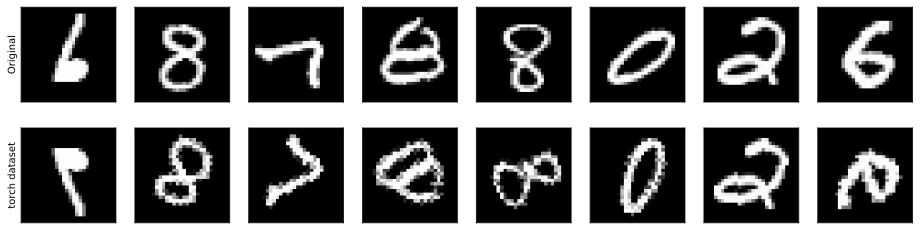

In [27]:
# import data from the dataloader, just like during training
X,y = next(iter(dataLoaded))


# create a figure
fig,axs = plt.subplots(2,8,figsize=(16,4))


# loop over images in the dataset
for i in range(8):

  # draw images
  axs[0,i].imshow(dataT[i,0,:,:].detach(),cmap='gray')
  axs[1,i].imshow(X[i,0,:,:].detach(),cmap='gray')

  # some niceties
  for row in range(2):
    axs[row,i].set_xticks([])
    axs[row,i].set_yticks([])

# row labels
axs[0,0].set_ylabel('Original')
axs[1,0].set_ylabel('torch dataset')

plt.show()

In [28]:
# Important to know: we haven't actually increased the amount of data
len(train_data)

8